In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy.interpolate import interp1d,RegularGridInterpolator
from scipy.optimize import least_squares
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Open Data, Get Rates of Single and Multi-Units

In [3]:
with open('./data_monk_rates'+'.txt', 'rb') as handle:
    data_rates_raw = np.loadtxt(handle)
    
idxs = np.unique(data_rates_raw[:,0])
cons = np.unique(data_rates_raw[:,1])
lsrs = np.unique(data_rates_raw[:,2])

data_rates = np.zeros((len(idxs),len(cons),len(lsrs)))

for i,idx in enumerate(idxs):
    for j,con in enumerate(cons):
        for k,lsr in enumerate(lsrs):
            data_rates[i,j,k] = data_rates_raw[np.logical_and(np.logical_and(data_rates_raw[:,0]==idx,
                                                                             data_rates_raw[:,1]==con),
                                                                             data_rates_raw[:,2]==lsr),3]

In [4]:
su_idxs = np.array([1,5,7,8,9,13,15,16,17,18,19,21,23,25,27,28,29,33,35,38,43,46,48,52,54,55,56,58,60,61,63,65,67,69,71,74,75,81,83,85,87,89,90,91,95,97,98,99,100,102,103,105,106,108,110]) - 1
mu_idxs = np.setdiff1d(np.arange(111),su_idxs)

su_rates = data_rates[su_idxs,:,:]
mu_rates = data_rates[mu_idxs,:,:]

# Bootstrap Response Statistics

In [5]:
def bootstrap(stat,rates,Nboot):
    Ncell = len(rates)
    boot_idxs = np.random.choice(np.arange(Ncell),size=(Ncell,Nboot), replace=True)
    
    test_stat = stat(rates[:2])
    if np.isscalar(test_stat):
        stat_shape = (1,)
    else:
        stat_shape = test_stat.shape
    boot_stats = np.zeros((Nboot,)+stat_shape)
    
    for boot_idx in range(Nboot):
        boot_stats[boot_idx] = stat(rates[boot_idxs[:,boot_idx]])
        
    return np.concatenate((np.mean(boot_stats,axis=0,keepdims=True),np.std(boot_stats,axis=0,keepdims=True)),0)

def resp_stats(rates):
    stats = np.zeros((6,6))
    
    stats[0,:] = np.mean(rates[:,:, 0],0)
    stats[1,:] = np.mean(rates[:,:,-1],0)
    stats[2,:] = np.std(rates[:,:, 0],0)
    stats[3,:] = np.std(rates[:,:,-1],0)
    stats[4,:] = np.std(rates[:,:,-1]-rates[:,:, 0],0)
    for con_idx in range(6):
        cov = np.cov(rates[:,con_idx, 0],rates[:,con_idx,-1]-rates[:,con_idx, 0],0)
        stats[5,con_idx] = cov[0,1]/cov[1,1]
    
    return stats

[[20.22138382 43.18403455 54.70902    64.32076    70.78721455 72.74625636]
 [30.672424   44.89918455 53.15055091 60.39506195 64.12994364 68.75836   ]
 [17.14886123 32.87827718 39.56994677 43.34970326 45.74103738 49.41498049]
 [37.24745554 43.56826699 45.83744347 50.11406124 48.19352741 52.92491502]
 [38.66264696 43.5586591  43.18346369 46.62591815 42.72248849 42.85495238]
 [-0.13430248 -0.28464441 -0.35647597 -0.35459308 -0.43689125 -0.40220606]]


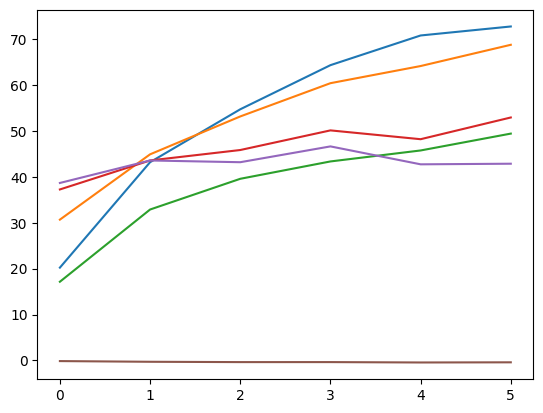

In [6]:
plt.plot(resp_stats(su_rates).T)
print(resp_stats(su_rates))

In [20]:
su_moments = np.transpose(bootstrap(resp_stats,su_rates,100000),(1,2,0))
mu_moments = np.transpose(bootstrap(resp_stats,mu_rates,100000),(1,2,0))

In [21]:
with open('./su_data_moments'+'.pkl', 'wb') as handle:
    pickle.dump(su_moments,handle)
    
with open('./mu_data_moments'+'.pkl', 'wb') as handle:
    pickle.dump(mu_moments,handle)